In [24]:
import os
import sys
import pypsa
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

sys.path.append(str(Path.cwd().parent / "scripts"))
from prepare_network import define_spatial

In [ ]:
nice_names = {
    "": "no domestic flexibility",
    "no flex": "no domestic flexibility",
    "ss": "saving session",
    "go": "overnight smart charging",
    "int": "fully flexible centralized charging",
    "v2g": "vehicle-to-grid",
    "cosy": "smart HP",
    "tank": "smart HP with hot water tank",
}

In [314]:
data1 = pd.read_csv(Path.cwd().parent / "results" / "pypsa-fes" / "csvs" / "flex_statistics.csv", index_col=[0,1], header=[0,1,2,3,4])
data2 = pd.read_csv(Path.cwd().parent / "results" / "pypsa-fes" / "csvs" / "flex_statistics_combined.csv", index_col=[0,1], header=[0,1,2,3,4])

In [315]:
idx = pd.IndexSlice

d = data2.loc[:, idx[:,:,:,:,'2050']]
d = data2.drop(d.columns, axis=1)

d.columns.get_level_values(4)

d = pd.concat((d, data1), axis=1)


In [316]:
# total = pd.concat([data2, data1], axis=1)

In [317]:
# pd.concat([data1,data2],axis=1).to_csv(Path.cwd().parent / "results" / "pypsa-fes" / "csvs" / "flex_statistics_combined.csv")
# d.to_csv(Path.cwd().parent / "results" / "pypsa-fes" / "csvs" / "flex_statistics_combined.csv")

In [269]:
data = pd.read_csv(Path.cwd().parent / "results" / "pypsa-fes" / "csvs" / "flex_statistics_combined.csv", index_col=[0,1], header=[0,1,2,3,4])

cols = data.columns.droplevel([0,1,3]).to_frame()
cols.loc[cols.flexopts.str.contains("Unnamed"), "flexopts"] = "no flex"

data.columns = cols.set_index(["flexopts", "year"]).index


In [270]:
idx = pd.IndexSlice

intermittent = pd.Index(["solar", "onwind", "offwind-ac", "offwind-dc"])
conventional = pd.Index(["OCGT", "CCGT", "nuclear", "biomass", "allam"])

# data.columns = data.columns.get_level_values(2)
data = data.groupby(level=1).sum()

In [271]:
process_label = lambda s: "\n".join([nice_names[tag] for tag in s.split("-")])

s = 'int-v2g-tank'
process_label(s)

'adding smart charging w/o V2G\nvehicle-to-grid - only v2g, does this make sense?\nadding smart heat w/ tank'

In [272]:
data.columns = [col for col in data.columns if "Unnamed" not in col]

KeyError: 'Unnamed: 3_level_2'

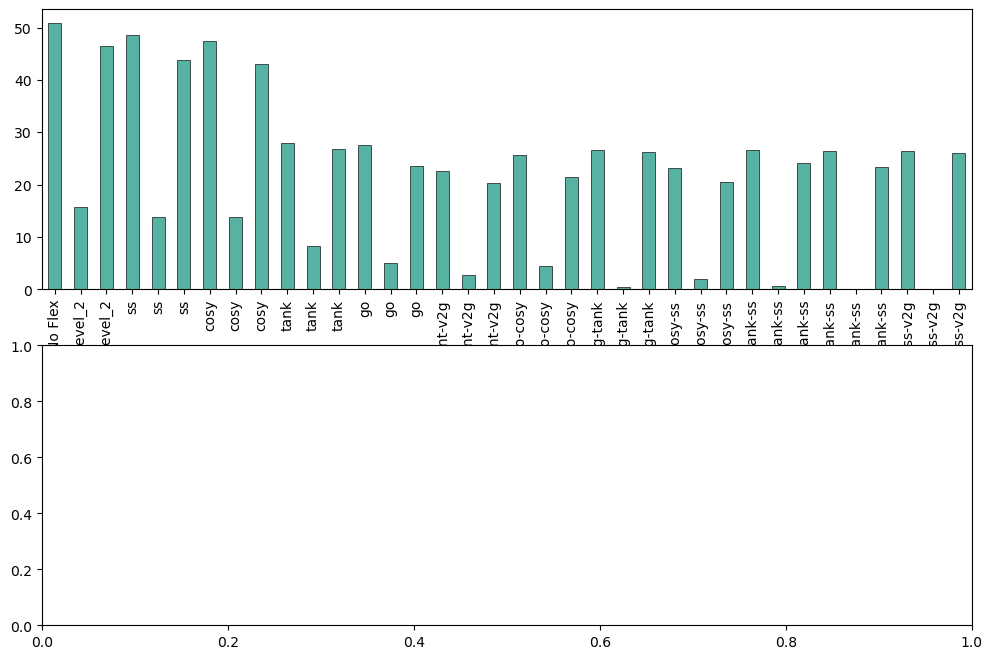

In [215]:
fig, axs = plt.subplots(2, 1, figsize=(12, 8))

bar_kwargs = {"align": "center", "alpha": 0.9, "color": "#44AA99", "edgecolor": "k", 'linewidth': 0.5}

d = (d:= data.loc["distribution_p_nom"]) - d.min()
d.mul(1e-3).plot.bar(ax=axs[0], label="Distribution", **bar_kwargs)

t = (t:= data.loc["transmission_p_nom"]) - t.min()

t.index = list(map(process_label, t.index))
t.mul(1e-3).plot.bar(ax=axs[1], label="Transmission", **bar_kwargs)


prepare_axis(axs)
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(2, 1, figsize=(12, 8))

i = (i:= data.loc[intermittent+"_energy"].sum()) - i.min()
i.mul(1e-6).plot.bar(ax=axs[0], label="Intermittent", **bar_kwargs)

c = (c:= data.loc[conventional+"_p_nom"].sum()) - c.min()

c.index = list(map(process_label, c.index))
c.mul(1e-3).plot.bar(ax=axs[1], label="Conventional", **bar_kwargs)

axs[0].set_ylabel("Distribution Capacity [GW]")
axs[1].set_ylabel("Transmission Capacity [GW]")
axs[0].set_ylabel("Unlocked Intermittent Generation [TWh]")
axs[1].set_ylabel("Dispatchable Generation Capacity [GW]")

prepare_axis(axs)
plt.tight_layout()
plt.show()

##### Joined plot

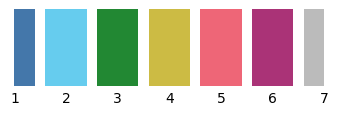

In [318]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


def get_colors(n=30, from_tech=True, diverging=True):
    
    if from_tech:
        with open(Path.cwd().parent / "config" / "config.yaml") as f:
            colors = yaml.safe_load(f)["plotting"]["tech_colors"]

        return np.random.choice(list(colors.values()), n, replace=False)
    
    elif not from_tech and diverging:
        return ["#4477AA", "#66CCEE", "#228833", "#CCBB44", "#EE6677", "#AA3377", "#BBBBBB"]
    
    elif not from_tech and not diverging:

        base_color = 'red'
        cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', [base_color, 'black'], N=7)

        return cmap(range(7))


colorlist = get_colors(from_tech=False, diverging=True)

fig, ax = plt.subplots(figsize=(4, 1))
for i, color in enumerate(colorlist):
    ax.bar(i, 1, color=color)

ax.set_xlim(0, 6)
ax.set_ylim(0, 1)
ax.set_xticks(range(7))
ax.set_xticklabels(range(1, 8))
ax.set_yticks([])
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.tick_params(axis='x', length=0)
ax.tick_params(axis='y', length=0)
plt.show()

In [319]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import yaml


idx = pd.IndexSlice

data = pd.read_csv(Path.cwd().parent / "results" / "pypsa-fes" / "csvs" / "flex_statistics_combined.csv", index_col=[0,1], header=[0,1,2,3,4])

cols = data.columns.droplevel([0,1,3]).to_frame()
cols.loc[cols.flexopts.str.contains("Unnamed"), "flexopts"] = "no flex"

data.columns = cols.set_index(["flexopts", "year"]).index

intermittent = pd.Index(["solar", "onwind", "offwind-ac", "offwind-dc"])
conventional = pd.Index(["OCGT", "CCGT", "nuclear", "biomass", "allam"])

data = data.groupby(level=1).sum()

"""
nice_names = {
    "No Flex": "No Flex",
    "ss": "Event Flexibility",
    "cosy": "Smart HP",
    "tank": "Smart HP + Tank",
    "go": "Smart Charging Night",
    "int": "Int. Charging",
    "v2g": "V2G",
}
"""

nice_names = {
    "": "zero flex",
    "no flex": "zero flex",
    # "cosy": "smart heat pump",
    # "tank": "smart heat pump w/ tank",
    # "v2g": "vehicle-to-grid",
    # "go": "overnight smart charging",
    # "int": "fully flexible charging",
    # "int-v2g": "fully flexible charging w/ V2G",
    # "ss": "saving session",
    "cosy": "adding smart heat w/o tank",
    "tank": "adding smart heat w/ tank",
    "v2g": "vehicle-to-grid - only v2g, does this make sense?",
    "go": "adding overnight smart charging",
    "int": "adding smart charging w/o V2G",
    "int-v2g": "adding smart charging w/ V2G",
    "ss": "adding saving sessions",
    # "int-tank-ss-v2g": "full flex",
    # "int-cosy-ss-v2g": "no tank",
    # "int-ss-v2g": "no heat flex",
    # "int-tank-ss": "no vehicle to grid",
    # "go-tank-ss-v2g": "charging flex only overnight",
    # "tank-ss-v2g": "no charging flex",
    # "int-tank-v2g": "no saving sessions",
    "int-tank-ss-v2g": "full flex",
    "int-cosy-ss-v2g": "removing hot water tank",
    "int-ss-v2g": "removing heat flex",
    "int-tank-ss": "removing vehicle to grid",
    "go-tank-ss-v2g": "enforcing shorter smart charging window",
    "tank-ss-v2g": "removing smart charging",
    "int-tank-v2g": "removing saving sessions",
}

colors = {
    "zero flex": colorlist[0],
    "full flex": colorlist[0],
    "adding smart heat w/o tank": colorlist[1],
    "removing hot water tank": colorlist[1],
    "adding smart heat w/ tank": colorlist[2],
    "removing heat flex": colorlist[2],
    "adding overnight smart charging": colorlist[3],
    "enforcing shorter smart charging window": colorlist[3],
    "adding smart charging w/ V2G": colorlist[4],
    "removing smart charging": colorlist[4],
    "adding smart charging w/o V2G": colorlist[5],
    "removing vehicle to grid": colorlist[5],
    "adding saving sessions": colorlist[6],
    "removing saving sessions": colorlist[6],
}

# colors = {
# "int-v2g": colorlist[3],
# "int-tank-ss": colorlist[3],
# "go": colorlist[4],
# "go-tank-ss-v2g": colorlist[4],
# "int": colorlist[5],
# "tank-ss-v2g": colorlist[5],
# "ss": colorlist[6],
# "int-tank-v2g": colorlist[6],
# }

In [320]:
def prepare_axis(axs):

    def prep_ax(ax):

        ax.grid(linestyle='--', linewidth=0.5)
        ax.set_axisbelow(True)
        # ax.legend()
        ax.spines[['top', 'right']].set_visible(False)
        ax.spines[['left', 'bottom']].set_visible(True)
        ax.spines[['left', 'bottom']].set_color('black')
        ax.tick_params(axis='x', colors='black')
        ax.tick_params(axis='y', colors='black')
        # xticklabels = ax.get_xticklabels()
        # ax.set_xticklabels(xticklabels, rotation=45, ha='right')

    try:
        for ax in axs.flatten():
            prep_ax(ax)
    except AttributeError:
        prep_ax(axs)

    # for ax in axs.flatten()[:2]:
    #     ax.set_xlabel("")
    #     ax.set_xticklabels([])
    

In [277]:
# colors = get_colors(from_tech=False, diverging=True)
# labels = pd.Index(data.columns.get_level_values(0).unique())
# labels = labels[~labels.str.contains("Unnamed")]
# (labels := set(labels)).add("No Flex")

# colors = {label: color for label, color in zip(labels, colors)}
# process_label = lambda s: "-".join([nice_names[tag] for tag in s.split("-")])

In [278]:
def make_barplots(
        series,
        x,
        ax,
        width=0.8,
        less_better=True,
        ):

    bar_kwargs = {
        "alpha": 0.9,
        "edgecolor": "k",
        'linewidth': 0.5,
        'width': width,
        }

    if not less_better:
        base = series.min()
        series -= base
    else:
        base = series.max()
        series = (series - base).abs()
    
    series = series.sort_values()

    for i, (idx, value) in enumerate(series.items()):

        offset = - len(series) / 2 * width + i * width

        ax.bar(
            x + offset,
            value,
            color=colors[idx],
            # label=process_label(idx),
            label=nice_names[idx],
            # width=width,
            **bar_kwargs,
            )

In [279]:
colors

{'zero flex': '#4477AA',
 'full flex': '#4477AA',
 'adding smart heat w/o tank': '#66CCEE',
 'removing hot water tank': '#66CCEE',
 'adding smart heat w/ tank': '#228833',
 'removing heat flex': '#228833',
 'adding overnight smart charging': '#CCBB44',
 'enforcing shorter smart charging window': '#CCBB44',
 'adding smart charging w/ V2G': '#EE6677',
 'removing smart charging': '#EE6677',
 'adding smart charging w/o V2G': '#AA3377',
 'removing vehicle to grid': '#AA3377',
 'adding saving session': '#BBBBBB',
 'removing saving sessions': '#BBBBBB'}

KeyError: 'tank-ss-v2g'

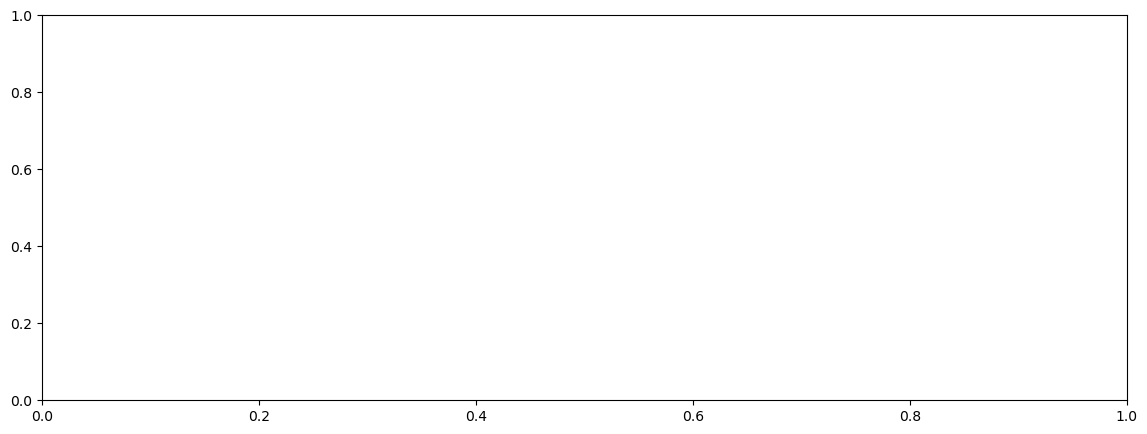

In [280]:
# data = pd.read_csv(Path.cwd().parent / "results" / "pypsa-fes" / "csvs" / "flex_statistics.csv", index_col=[0,1], header=[0,1,2,3,4])

# base can be "none" or "full"
# if none: individual types of flex are added to a system without any other flex
# if full: individual types of flex are switched off with all other types still switched on
base = "full"

def filter_df(data, base):

    df = pd.DataFrame({"name": data.columns.get_level_values(0).unique()})
    df["length"] = df["name"].apply(lambda s: len(s.split("-")))

    if base == "full":
        return list(df.loc[df.length >= 3, "name"])
    elif base == "none":
        return list(df.loc[df.length < 3, "name"])
    
    assert False, "base should be either 'full' or 'none', not {}".format(base)


name = [
    "int", "cap", "tra", "dis",
]
ylabels = [
    "Unlocked Intermittent Generation [TWh]",
    "Prevented Dispatchable Generation Capacity [GW]",
    "Prevented Transmission Capacity [GW]",
    "Prevented Distribution Capacity [GW]",
]
indexes = {
    "int": intermittent+"_energy",
    "cap": conventional+"_p_nom",
    "tra": "transmission_p_nom",
    "dis": "distribution_p_nom",
}



for i, (name, ylabel) in enumerate(zip(name, ylabels)):

    if name == "int":
        fac = 1e-6
    else:
        fac = 1e-3

    fig, ax = plt.subplots(1, 1, figsize=(14, 5))

    for year in data.columns.get_level_values(1).unique().astype(str):

        df = data.loc[:, idx[filter_df(data, base) ,year]]
        df.columns = df.columns.get_level_values(0)

        if name in ["int", "cap"]:
            make_barplots(df.loc[indexes[name]].sum().mul(fac), int(year), ax, less_better=False)
        else:
            make_barplots(df.loc[indexes[name]].mul(fac), int(year), ax, less_better=False)

    prepare_axis(ax)
    ax.set_ylabel(ylabel)

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))

    fig.legend(
        by_label.values(),
        by_label.keys(),
        bbox_to_anchor=(0.87, -0.01),
        fancybox=True,
        shadow=True,
        ncol=3,
        )

    plt.tight_layout()
    plt.show()

    break



[Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')]


C:\Users\lukas\AppData\Local\Temp\ipykernel_8736\3700393518.py:91: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['', '', '2030', '', '2040', '', '2050'])


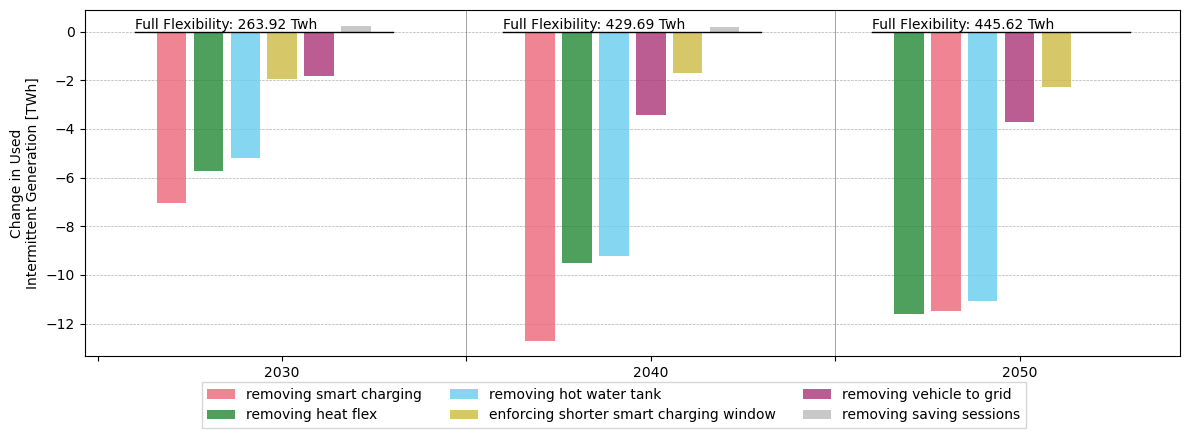

In [321]:
width = 1
cushion = 0.2

bar_kwargs = {
    "alpha": 0.8,
    # "edgecolor": "k",
    # 'linewidth': 0.5,
    'width': width-cushion,
    }

name = "int"


if name == "int":
    fac = 1e-6
else:
    fac = 1e-3

fig, ax = plt.subplots(1, 1, figsize=(12, 4))

idx = pd.IndexSlice
# for year in data.columns.get_level_values(1).unique().astype(str):
for year in ["2030", "2040", "2050"]:

    base = "full"

    df = data.loc[:, idx[filter_df(data, base), year]]
    df.columns = df.columns.get_level_values(0)

    # make_barplots(df.loc[indexes[name]].sum().mul(1e-6), int(year), ax, less_better=False)

    if name in ["int", "cap"]:
        plot_data = df.loc[indexes[name]].sum().mul(fac)
    else:
        plot_data = df.loc[indexes[name]].mul(fac)

    base = plot_data.loc["int-tank-ss-v2g"]

    l = len(plot_data)

    ax.plot(
        [float(year) - (l*width // 2 + 1) * width, float(year) + (l*width // 2) * width],
        [0., 0.],
        color="k",
        linewidth=1,
    )
    ax.text(
        float(year) - (l-1) / 2 * width - width,
        0, 
        f"Full Flexibility: {np.around(base, decimals=2)} Twh",
        ha="left",
        va="bottom",
        )

    plot_data = plot_data.drop("int-tank-ss-v2g").sort_values().sub(base)
    l = len(plot_data)
    
    for i, (index, value) in enumerate(plot_data.items()):

        offset = - l / 2 * width + i * width

        ax.bar(
            float(year) + offset,
            value,
            # color=colors[index],
            color=colors[nice_names[index]],
            # label=process_label(idx),
            label=nice_names[index],
            # width=width,
            **bar_kwargs,
            )

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))

fig.legend(
    by_label.values(),
    by_label.keys(),
    bbox_to_anchor=(0.865, 0.05),
    fancybox=False,
    shadow=False,
    ncol=3,
    )

ax.set_ylabel("Change in Used\nIntermittent Generation [TWh]")

ax.axvline(2035, color="k", linewidth=0.5, alpha=0.5)
ax.axvline(2045, color="k", linewidth=0.5, alpha=0.5)

print(ax.get_xticklabels())
ax.set_xticklabels(['', '', '2030', '', '2040', '', '2050'])

ax.grid(linestyle='--', linewidth=0.5, axis="y")
ax.set_axisbelow(True)

plt.tight_layout()
plt.savefig("removal_of_flexibility_intermittent_generation.pdf")
plt.show()

flexopts
tank       17.045609
int-v2g    16.604385
int        11.942107
go          8.150759
cosy        0.077936
ss         -0.061892
dtype: float64
[Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')]


C:\Users\lukas\AppData\Local\Temp\ipykernel_8736\2722138682.py:73: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['', '', '2030', '', '2040', '', '2050'])


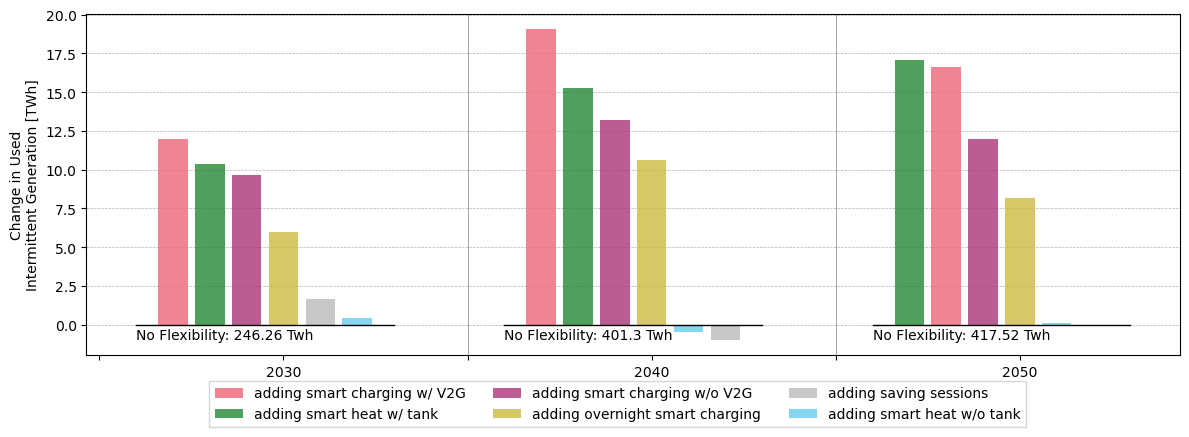

In [322]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))

base = "none"

# for year in data.columns.get_level_values(1).unique().astype(str):
for year in ["2030", "2040", "2050"]:

    df = data.loc[:, idx[filter_df(data, base), year]]
    df.columns = df.columns.get_level_values(0)

    if name in ["int", "cap"]:
        plot_data = df.loc[indexes[name]].sum().mul(fac)
    else:
        plot_data = df.loc[indexes[name]].mul(fac)

    base_no_flex = plot_data.loc["no flex"]
    l = len(plot_data)

    ax.plot(
        [float(year) - (l*width // 2 + 1) * width, float(year) + (l*width // 2) * width],
        [0., 0.],
        color="k",
        linewidth=1,
    )
    ax.text(
        float(year) - (l-1) / 2 * width - width,
        -0.2,
        f"No Flexibility: {np.around(base_no_flex, decimals=2)} Twh",
        ha="left",
        va="top",
        )

    plot_data = plot_data.drop("no flex").sort_values(ascending=False).sub(base_no_flex)

    l = len(plot_data)

    if int(year) == 2050:
        print(plot_data)
    
    for i, (index, value) in enumerate(plot_data.items()):

        offset = - l / 2 * width + i * width

        ax.bar(
            float(year) + offset,
            value,
            # color=colors[index],
            color=colors[nice_names[index]],
            # label=process_label(idx),
            label=nice_names[index],
            # width=width,
            **bar_kwargs,
            )

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))

fig.legend(
    by_label.values(),
    by_label.keys(),
    bbox_to_anchor=(0.865, 0.05),
    fancybox=False,
    shadow=False,
    ncol=3,
    )

ax.set_ylabel("Change in Used\nIntermittent Generation [TWh]")

ax.axvline(2035, color="k", linewidth=0.5, alpha=0.5)
ax.axvline(2045, color="k", linewidth=0.5, alpha=0.5)

print(ax.get_xticklabels())
ax.set_xticklabels(['', '', '2030', '', '2040', '', '2050'])

ax.grid(linestyle='--', linewidth=0.5, axis="y")
ax.set_axisbelow(True)

plt.tight_layout()
plt.savefig("addition_of_flexibility_intermittent_generation.pdf")
plt.show()